# 8-Bit Autonomous Driving

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

![Sample](./images/driving_sample.gif)

## Review Training Data

Read in the training.csv data.  This is the data collected running the `01_training.py` file.


Column 0 = target value

In [2]:
from driver_util import show_road, get_training_data, direction
road_matrix, df = get_training_data("training.csv")
df.head()


,0,1,2,3,4,5,6,7,8,9,...,241,242,243,244,245,246,247,248,249,250
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,1,2,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,1,2,2,2,...,0,0,0,0,0,0,0,0,0,0
3,2,0,0,0,0,0,1,2,2,2,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,1,2,2,2,...,0,0,0,0,0,0,0,0,0,0


Review different samples, the road configuration at that row and the target value

[[0 0 0 0 0 0 1 2 2 2 2 2 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 2 2 2 2 2 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 2 2 2 2 2 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 2 2 2 2 2 1 0 0 0 0 0 0 0 0 0 0 0]]


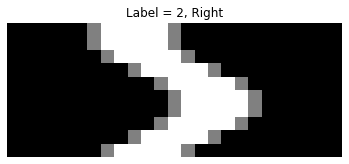

In [3]:
# 0 - offroad
# 1 - shoulder
# 2 - road
row = 33
show_road(road_matrix[row][1:], "Label = {}, {}".format(road_matrix[row][0], direction[road_matrix[row][0]]))

## Train a Machine Learning Model

Train a machine learning model on all 250 features to get a baseline accuracy before we reduce dimensions.

We will only use a LogisticRegression algorithm, however the `02_model_training.py` checks a number of models

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier


Create X, y variables

In [5]:
X = df.loc[:, 1:]
y = df.loc[:, 0]


In [6]:
X.shape

(150, 250)

In [7]:
y.shape

(150,)

Use cross_val_score to measure performance of model.  Note that the `02_model_training.py` script uses GridSearchCV to find the best parameters.

In [8]:
model = KNeighborsClassifier(n_neighbors=2, weights='distance')

In [9]:
cv_scores = cross_val_score(model, X, y, cv=5)
print(cv_scores, cv_scores.mean())


[0.73333333 0.76666667 0.83333333 0.86666667 0.76666667] 0.7933333333333333


# Reduce Dimensions with an AutoEncoder

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import MinMaxScaler

We need to decide on what the final dimension or number of columns we would like to reduce the dataset to.  

This is somewhat arbitrary and we should try a number of dimensions

In [11]:
min_dims = 32

In [12]:
input_size = X.shape[1]
layer_1 = 128
layer_2 = 64
layer_3 = 32
layer_last = min_dims



In [13]:
# Create Encoder
encoder = Sequential()
encoder.add(Dense(layer_1, input_shape=(input_size,), activation="relu"))
encoder.add(Dense(layer_2,activation="relu"))
encoder.add(Dense(layer_3,activation="relu"))
encoder.add(Dense(layer_last,activation="relu"))



2022-02-02 19:28:40.293761: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
# Create Decoder
decoder = Sequential()
decoder.add(Dense(layer_3, input_shape=(layer_last,), activation="relu"))
decoder.add(Dense(layer_2, activation="relu"))
decoder.add(Dense(layer_1, activation="relu"))
decoder.add(Dense(input_size, activation="relu"))


In [15]:
autoencoder = Sequential([encoder, decoder])
autoencoder.compile(loss="mse", optimizer=SGD(learning_rate=0.1))


Because we are not performing a traditional train/test split we are going to use all of the data to train the autoencoder.

In [16]:
encoder_scaler = MinMaxScaler()
X_scaled = encoder_scaler.fit_transform(X)

In [17]:
autoencoder.fit(X_scaled, X_scaled, epochs=2000)


Epoch 1/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.2108
Epoch 2/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.2070
Epoch 3/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.2023
Epoch 4/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.1968
Epoch 5/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.1908
Epoch 6/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.1846
Epoch 7/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.1785
Epoch 8/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.1721
Epoch 9/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.1662
Epoch 10/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.1608
Epoch 11/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.1559
Epoch 12/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.1515
Epoch 13/2000
5/5 [==============================

5/5 [==============================] - 0s 2ms/step - loss: 0.1023
Epoch 104/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.1019
Epoch 105/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.1013
Epoch 106/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.1009
Epoch 107/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.1004
Epoch 108/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0999
Epoch 109/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0995
Epoch 110/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0991
Epoch 111/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0986
Epoch 112/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0981
Epoch 113/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0977
Epoch 114/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0972
Epoch 115/2000
5/5 [=======================

5/5 [==============================] - 0s 2ms/step - loss: 0.0625
Epoch 205/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0623
Epoch 206/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0622
Epoch 207/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0621
Epoch 208/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0620
Epoch 209/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0618
Epoch 210/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0617
Epoch 211/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0616
Epoch 212/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0615
Epoch 213/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0614
Epoch 214/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0612
Epoch 215/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0611
Epoch 216/2000
5/5 [=======================

5/5 [==============================] - 0s 1ms/step - loss: 0.0530
Epoch 306/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0529
Epoch 307/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0528
Epoch 308/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0527
Epoch 309/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0527
Epoch 310/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0526
Epoch 311/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0525
Epoch 312/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0524
Epoch 313/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0523
Epoch 314/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0523
Epoch 315/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0521
Epoch 316/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0520
Epoch 317/2000
5/5 [=======================

5/5 [==============================] - 0s 1ms/step - loss: 0.0481
Epoch 407/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0481
Epoch 408/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0481
Epoch 409/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0480
Epoch 410/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0480
Epoch 411/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0480
Epoch 412/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0480
Epoch 413/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0479
Epoch 414/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0479
Epoch 415/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0479
Epoch 416/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0478
Epoch 417/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0478
Epoch 418/2000
5/5 [=======================

5/5 [==============================] - 0s 1ms/step - loss: 0.0443
Epoch 508/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0443
Epoch 509/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0443
Epoch 510/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0443
Epoch 511/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0443
Epoch 512/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0442
Epoch 513/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0442
Epoch 514/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0442
Epoch 515/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0442
Epoch 516/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0442
Epoch 517/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0442
Epoch 518/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0442
Epoch 519/2000
5/5 [=======================

5/5 [==============================] - 0s 1ms/step - loss: 0.0431
Epoch 609/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0431
Epoch 610/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0431
Epoch 611/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0431
Epoch 612/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0431
Epoch 613/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0431
Epoch 614/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0431
Epoch 615/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0430
Epoch 616/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0430
Epoch 617/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0431
Epoch 618/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0431
Epoch 619/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0430
Epoch 620/2000
5/5 [=======================

5/5 [==============================] - 0s 1ms/step - loss: 0.0424
Epoch 710/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0424
Epoch 711/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0424
Epoch 712/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0423
Epoch 713/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0424
Epoch 714/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0423
Epoch 715/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0424
Epoch 716/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0423
Epoch 717/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0423
Epoch 718/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0423
Epoch 719/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0423
Epoch 720/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0423
Epoch 721/2000
5/5 [=======================

5/5 [==============================] - 0s 1ms/step - loss: 0.0419
Epoch 811/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0418
Epoch 812/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0418
Epoch 813/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0418
Epoch 814/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0418
Epoch 815/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0418
Epoch 816/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0418
Epoch 817/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0418
Epoch 818/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0418
Epoch 819/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0418
Epoch 820/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0418
Epoch 821/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0418
Epoch 822/2000
5/5 [=======================

5/5 [==============================] - 0s 1ms/step - loss: 0.0414
Epoch 912/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0414
Epoch 913/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0414
Epoch 914/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0413
Epoch 915/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0414
Epoch 916/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0414
Epoch 917/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0414
Epoch 918/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0413
Epoch 919/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0413
Epoch 920/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0413
Epoch 921/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0413
Epoch 922/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0413
Epoch 923/2000
5/5 [=======================

5/5 [==============================] - 0s 1ms/step - loss: 0.0410
Epoch 1013/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0409
Epoch 1014/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0409
Epoch 1015/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0409
Epoch 1016/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0410
Epoch 1017/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0409
Epoch 1018/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0409
Epoch 1019/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0409
Epoch 1020/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0409
Epoch 1021/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0409
Epoch 1022/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0409
Epoch 1023/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0409
Epoch 1024/2000
5/5 [===========

5/5 [==============================] - 0s 1ms/step - loss: 0.0405
Epoch 1113/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0405
Epoch 1114/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0405
Epoch 1115/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0405
Epoch 1116/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0405
Epoch 1117/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0406
Epoch 1118/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0405
Epoch 1119/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0405
Epoch 1120/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0405
Epoch 1121/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0405
Epoch 1122/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0405
Epoch 1123/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0405
Epoch 1124/2000
5/5 [===========

5/5 [==============================] - 0s 1ms/step - loss: 0.0402
Epoch 1213/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0402
Epoch 1214/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0402
Epoch 1215/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0402
Epoch 1216/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0401
Epoch 1217/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0402
Epoch 1218/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0401
Epoch 1219/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0402
Epoch 1220/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0401
Epoch 1221/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0401
Epoch 1222/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0401
Epoch 1223/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0401
Epoch 1224/2000
5/5 [===========

Epoch 1312/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0398
Epoch 1313/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0398
Epoch 1314/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0398
Epoch 1315/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0398
Epoch 1316/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0398
Epoch 1317/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0398
Epoch 1318/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0398
Epoch 1319/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0398
Epoch 1320/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0398
Epoch 1321/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0398
Epoch 1322/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0398
Epoch 1323/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0398
Epoch 1324/2000


5/5 [==============================] - 0s 1ms/step - loss: 0.0394
Epoch 1412/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0394
Epoch 1413/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0394
Epoch 1414/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0394
Epoch 1415/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0394
Epoch 1416/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0394
Epoch 1417/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0394
Epoch 1418/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0394
Epoch 1419/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0394
Epoch 1420/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0394
Epoch 1421/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0394
Epoch 1422/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0394
Epoch 1423/2000
5/5 [===========

5/5 [==============================] - 0s 1ms/step - loss: 0.0391
Epoch 1512/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0390
Epoch 1513/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0391
Epoch 1514/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0391
Epoch 1515/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0390
Epoch 1516/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0390
Epoch 1517/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0390
Epoch 1518/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0391
Epoch 1519/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0390
Epoch 1520/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0390
Epoch 1521/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0390
Epoch 1522/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0390
Epoch 1523/2000
5/5 [===========

5/5 [==============================] - 0s 1ms/step - loss: 0.0387
Epoch 1612/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0387
Epoch 1613/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0387
Epoch 1614/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0387
Epoch 1615/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0386
Epoch 1616/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0387
Epoch 1617/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0387
Epoch 1618/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0386
Epoch 1619/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0386
Epoch 1620/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0386
Epoch 1621/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0386
Epoch 1622/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0386
Epoch 1623/2000
5/5 [===========

5/5 [==============================] - 0s 1ms/step - loss: 0.0383
Epoch 1712/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0383
Epoch 1713/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0383
Epoch 1714/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0383
Epoch 1715/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0383
Epoch 1716/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0383
Epoch 1717/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0383
Epoch 1718/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0383
Epoch 1719/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0383
Epoch 1720/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0383
Epoch 1721/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0383
Epoch 1722/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0383
Epoch 1723/2000
5/5 [===========

5/5 [==============================] - 0s 1ms/step - loss: 0.0380
Epoch 1812/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0380
Epoch 1813/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0379
Epoch 1814/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0380
Epoch 1815/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0379
Epoch 1816/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0380
Epoch 1817/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0379
Epoch 1818/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0380
Epoch 1819/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0379
Epoch 1820/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0379
Epoch 1821/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0379
Epoch 1822/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0379
Epoch 1823/2000
5/5 [===========

5/5 [==============================] - 0s 1ms/step - loss: 0.0376
Epoch 1912/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0376
Epoch 1913/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0376
Epoch 1914/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0376
Epoch 1915/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0376
Epoch 1916/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0376
Epoch 1917/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0376
Epoch 1918/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0376
Epoch 1919/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0376
Epoch 1920/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0376
Epoch 1921/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0376
Epoch 1922/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0376
Epoch 1923/2000
5/5 [===========

<AxesSubplot:>

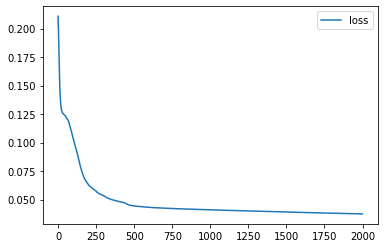

In [18]:
pd.DataFrame(autoencoder.history.history).plot()

## How we does the autoencoder do when reconstructing the road
display the output of the AutoEncoder

In [19]:
def show_autoencoder_results(sample_index):
    fig = plt.figure(figsize=(16,6))
    gs = fig.add_gridspec(1, 2)
    l_ax = fig.add_subplot(gs[0, 0])
    r_ax = fig.add_subplot(gs[0, 1])
    l_ax.imshow(X.iloc[sample_index].values.reshape((10,25)) * (255//2))
    decoded_road = autoencoder.predict(X.iloc[sample_index].values.reshape(1,250))
    print("Decoded Road 1 decimal")
    print(decoded_road.reshape((10,25)).round(1))
    print("Decoded Road rounded int")
    print(decoded_road.reshape((10,25)).round(0).astype(int))
    print("Original Road")
    print(X.iloc[sample_index].values.reshape((10,25)))
    
    r_ax.imshow(decoded_road.reshape((10,25)).round(0).astype(int) * (255//2))
    plt.show()

Decoded Road 1 decimal
[[0.  0.  0.  0.  0.  0.1 1.  0.  0.  2.  1.9 1.8 1.  0.1 0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.9 2.1 0.  2.  2.  1.8 0.8 0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.9 1.8 2.  2.  1.9 1.8 0.9 0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.9 0.  2.  2.1 1.9 1.8 1.1 0.  0.
  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.1 0.  0.  0.  0.  0.  0.  0.  0.9 1.8 2.1 2.2 2.  1.9 1.
  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.9 1.9 2.  1.9 2.1 0.
  1.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.9 0.  2.  2.  1.8 1.9
  1.1 0.1 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8 0.  2.  0.  0.  0.  1.1
  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.9 1.8 1.9 1.9 1.8 1.7 0.9 0.1 0.
  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  1.8 1

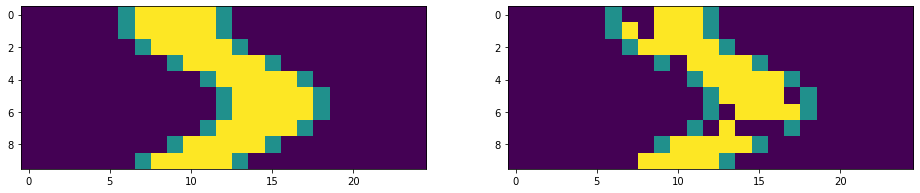

In [20]:
show_autoencoder_results(23)

Decoded Road 1 decimal
[[0.  0.  0.  0.  0.  0.  0.  0.  0.  1.9 2.1 2.  1.8 1.4 0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.3 1.6 1.8 0.  2.1 1.8 1.4 0.8 0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  2.  2.1 2.  2.1 1.9 0.8 0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  1.2 2.2 2.1 2.1 2.1 0.  0.8 0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  1.1 1.8 2.  2.1 2.2 1.8 0.9 0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.2 1.  0.  0.  2.2 2.  1.8 0.8 0.  0.1 0.
  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1 1.2 1.9 2.1 0.  1.9 1.9 0.7 0.
  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1 1.2 0.  1.8 0.  0.  0.  0.7
  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.2 0.5 2.  2.  1.9 2.1 1.8 0.
  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.

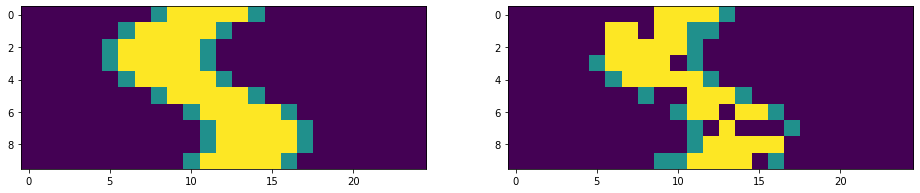

In [21]:
show_autoencoder_results(45)

Decoded Road 1 decimal
[[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.2 1.1 1.9 0.  2.  2.  1.8
  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1 1.1 1.9 2.  1.9 2.1
  2.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.9 1.7 2.  2.  2.
  1.9 1.  0.1 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.9 1.8 2.  2.1 2.  0.
  1.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.9 1.8 1.9 2.  2.1 2.  0.9 0.2
  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.1 1.  0.  0.  2.  2.  1.9 0.9 0.1 0.1 0.
  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  1.1 2.  2.  2.1 2.  1.8 0.  0.1 0.  0.  0.
  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.1 1.1 2.  2.  2.  1.9 0.  0.8 0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  1.9 1.9 1.9 2.  1.8 0.8 0.  0.  0.
  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  

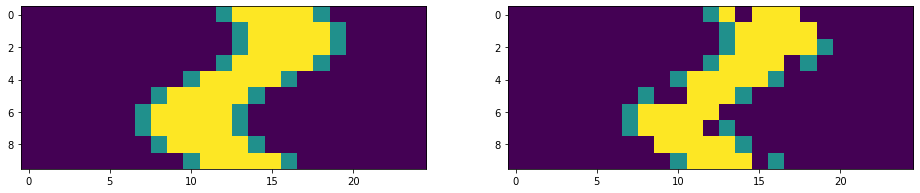

In [22]:
show_autoencoder_results(119)

## Use encoder to reduce dimensionality
Just use the encoder to reduce the dimensionality of the original dataset

In [23]:
X_scaled.shape

(150, 250)

In [24]:
# use encoder to compress or remove dimensionality
X_dim_reduced = encoder.predict(X_scaled)


In [25]:
X_dim_reduced.shape

(150, 32)

In [26]:
df_reduced = pd.DataFrame(X_dim_reduced)
df_reduced.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,7.345205,0.0,0.0,0.0,0.0,0.0,5.944205,2.043151,6.108237,0.509175,...,3.809787,5.639811,0.0,0.0,8.486442,0.0,1.237266,0.0,8.004673,0.934626
1,6.097001,0.0,0.0,0.0,0.0,0.0,5.358780,2.543047,5.991023,0.168630,...,2.859101,5.875680,0.0,0.0,8.146005,0.0,1.532043,0.0,6.128814,1.675421
2,5.294048,0.0,0.0,0.0,0.0,0.0,3.541825,2.694123,5.634313,0.328372,...,2.473224,6.083612,0.0,0.0,7.470112,0.0,2.226399,0.0,3.299158,2.709960
3,4.796915,0.0,0.0,0.0,0.0,0.0,2.775427,2.629244,5.211340,0.886908,...,3.250656,6.673686,0.0,0.0,8.097740,0.0,2.543997,0.0,1.685777,3.520905
4,5.032829,0.0,0.0,0.0,0.0,0.0,1.346458,1.916380,3.424022,1.639399,...,4.691604,6.150311,0.0,0.0,7.000952,0.0,2.436378,0.0,0.470773,3.417642


## Train a Machine Learning Model on new dataset

In [27]:
X_dim_reduced.shape

(150, 32)

In [28]:
y.shape

(150,)

In [29]:
model = KNeighborsClassifier(n_neighbors=2, weights='distance')
cv_scores = cross_val_score(model, X_dim_reduced, y, cv=5)
print(cv_scores, cv_scores.mean())




[0.66666667 0.76666667 0.83333333 0.86666667 0.76666667] 0.78


In [365]:
results = [
    [1, 0.82],
    [2, 0.77],
    [4, 0.83],
    [8, 0.78],
    [16, 0.87],
    [32, 0.87],
    [64, 0.87],
    [128, 0.87],
    [1,0.75],
    [1,0.78],
    [1, 0.86],
    [4, 0.81],
    [4, 0.79],
    [4, 0.85],
    [16, 0.86],
    [16, 0.86],
    [8, 0.87]
    
]

In [366]:
df_results = pd.DataFrame(results, columns =['Dims', 'Accuracy'])

In [367]:
df_results

,Dims,Accuracy
0,1,0.82
1,2,0.77
2,4,0.83
3,8,0.78
4,16,0.87
5,32,0.87
6,64,0.87
7,128,0.87
8,1,0.75
9,1,0.78


In [368]:
print(df_results.groupby(['Dims'])[['Accuracy']].mean())

      Accuracy
Dims          
1     0.802500
2     0.770000
4     0.820000
8     0.825000
16    0.863333
32    0.870000
64    0.870000
128   0.870000
